In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error

In [2]:
df = pd.read_csv("../DBtrainrides_final_result.csv")

In [3]:
label_encoder = LabelEncoder()

In [4]:
def fill_missing_times(group):
    # Iterate through the rows in the group and find rows with NaT values
    for i in range(len(group)):
        # Check if both arrival_plan and departure_plan are NaT
        if pd.isna(group.iloc[i]['arrival_plan']) and pd.isna(group.iloc[i]['departure_plan']):
            # Try to find the next row in the group with a valid arrival_plan
            next_row = group.iloc[i + 1:] if i + 1 < len(group) else pd.DataFrame()
            
            # If the next row exists and has a valid arrival_plan, fill the NaT
            if not next_row.empty and pd.notna(next_row.iloc[0]['arrival_plan']):
                next_arrival = next_row.iloc[0]['arrival_plan']
                # Subtract 5 minutes from the next valid arrival_plan
                group.at[group.index[i], 'arrival_plan'] = next_arrival - pd.Timedelta(minutes=5)
                # Set departure_plan equal to arrival_plan (or adjust logic if needed)
                group.at[group.index[i], 'departure_plan'] = group.iloc[i]['arrival_plan']
    return group

In [5]:
# df["label_info_encoded"] = label_encoder.fit_transform(df["transformed_info_message"])
message_order = ['No message', 'Information', 'Bauarbeiten', 'Störung', 'Großstörung']

df['transformed_info_message'] = pd.Categorical(
    df['transformed_info_message'],
    categories=message_order,
    ordered=True
)

df["label_info_encoded"] = df["transformed_info_message"].cat.codes

df['arrival_plan'] = pd.to_datetime(df['arrival_plan'], errors='coerce')
df['departure_plan'] = pd.to_datetime(df['departure_plan'], errors='coerce')

df = df.sort_values(by=["ID_Base", "ID_Timestamp", "stop_number"])
df = df.groupby(["ID_Base", "ID_Timestamp"], group_keys=False).apply(fill_missing_times)

# Find the min and max for arrival and departure
arrival_min = df['arrival_plan'].min()
arrival_max = df['arrival_plan'].max()
departure_min = df['departure_plan'].min()
departure_max = df['departure_plan'].max()

# Normalize arrival and departure times to [0, 1]
df['arrival_normalized'] = (df['arrival_plan'] - arrival_min) / (arrival_max - arrival_min)
df['departure_normalized'] = (df['departure_plan'] - arrival_min) / (arrival_max - arrival_min)

df = df.dropna(subset=['arrival_plan', 'departure_plan'])
# Replace naN values in targets with 0 because they are all coming from the first stop of a train ride (others are filtered out above):
df["arrival_delay_m"]= df["arrival_delay_m"].fillna(0)

# Replace strange NaN in IBNR, long and lat
df["IBNR"] = df["IBNR"].fillna(0.0)
df

/tmp/ipykernel_54967/1027716350.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(["ID_Base", "ID_Timestamp"], group_keys=False).apply(fill_missing_times)


,ID_Base,ID_Timestamp,stop_number,IBNR,long,lat,arrival_plan,departure_plan,arrival_delay_m,transformed_info_message,prev_arrival_delay_m,prev_departure_delay_m,weighted_avg_prev_delay,max_station_number,station_progress,label_info_encoded,arrival_normalized,departure_normalized
1210013,-9223176950731764733,2407040400,2,8005613.0,9.250030,53.101242,2024-07-11 04:16:00,2024-07-11 04:16:00,0.0,No message,0.0,0.0,0.0,2,1.00,0,0.455571,0.455571
1210014,-9223176950731764733,2407080400,2,8005613.0,9.250030,53.101242,2024-07-08 04:16:00,2024-07-08 04:16:00,0.0,No message,0.0,0.0,0.0,2,1.00,0,0.028102,0.028102
1210015,-9223176950731764733,2407090400,2,8005613.0,9.250030,53.101242,2024-07-09 04:16:00,2024-07-09 04:16:00,0.0,No message,0.0,0.0,0.0,2,1.00,0,0.170592,0.170592
1210016,-9223176950731764733,2407100400,2,8005613.0,9.250030,53.101242,2024-07-10 04:16:00,2024-07-10 04:16:00,0.0,No message,0.0,0.0,0.0,2,1.00,0,0.313081,0.313081
1210017,-9223176950731764733,2407120400,2,8005613.0,9.250030,53.101242,2024-07-12 04:16:00,2024-07-12 04:16:00,0.0,No message,0.0,0.0,0.0,2,1.00,0,0.598061,0.598061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2417320,9220892137995967708,2407111516,3,8001908.0,7.008821,51.404517,2024-07-11 15:23:00,2024-07-11 15:23:00,0.0,Bauarbeiten,0.0,0.0,0.0,4,0.75,2,0.521571,0.521571
2417321,9220892137995967708,2407111516,4,8001896.0,7.023296,51.422853,2024-07-11 15:26:00,2024-07-11 15:26:00,0.0,Bauarbeiten,0.0,0.0,0.0,4,1.00,2,0.521868,0.521868
2417322,9220892137995967708,2407121516,2,8001915.0,6.997845,51.386828,2024-07-12 15:20:00,2024-07-12 15:20:00,0.0,Information,0.0,0.0,0.0,4,0.50,1,0.663764,0.663764
2417323,9220892137995967708,2407121516,3,8001908.0,7.008821,51.404517,2024-07-12 15:23:00,2024-07-12 15:23:00,0.0,Information,0.0,0.0,0.0,4,0.75,1,0.664061,0.664061


In [6]:
target = df["arrival_delay_m"]
unique_base_ids = df['ID_Base'].unique()
np.random.seed(42)  # For reproducibility, if desired
shuffled_ids = np.random.permutation(unique_base_ids)
split_index = int(0.8 * len(shuffled_ids))

base_ids_80 = shuffled_ids[:split_index]  # 80% of Base_IDs
base_ids_20 = shuffled_ids[split_index:]  # 20% of Base_IDs

# Step 3: Split the dataframe based on the Base_ID sets
X_train = df[df['ID_Base'].isin(base_ids_80)]
X_test = df[df['ID_Base'].isin(base_ids_20)]

y_train = X_train["arrival_delay_m"]
y_test = X_test["arrival_delay_m"] 

X_train = X_train.drop(columns=["arrival_delay_m", "transformed_info_message","arrival_plan","departure_plan"])

X_test = X_test.drop(columns=["arrival_delay_m", "transformed_info_message","arrival_plan","departure_plan"])

In [7]:
regression_tree = DecisionTreeRegressor(max_depth=10, min_samples_leaf=5, max_leaf_nodes=10)
# Train on scaled data
regression_tree.fit(X_train, y_train)

# Predict on the test data
y_pred = regression_tree.predict(X_test)

# Calculate Mean Squared Error as a performance metric
mse = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mse)

Mean Absolute Error: 0.8174893341767202


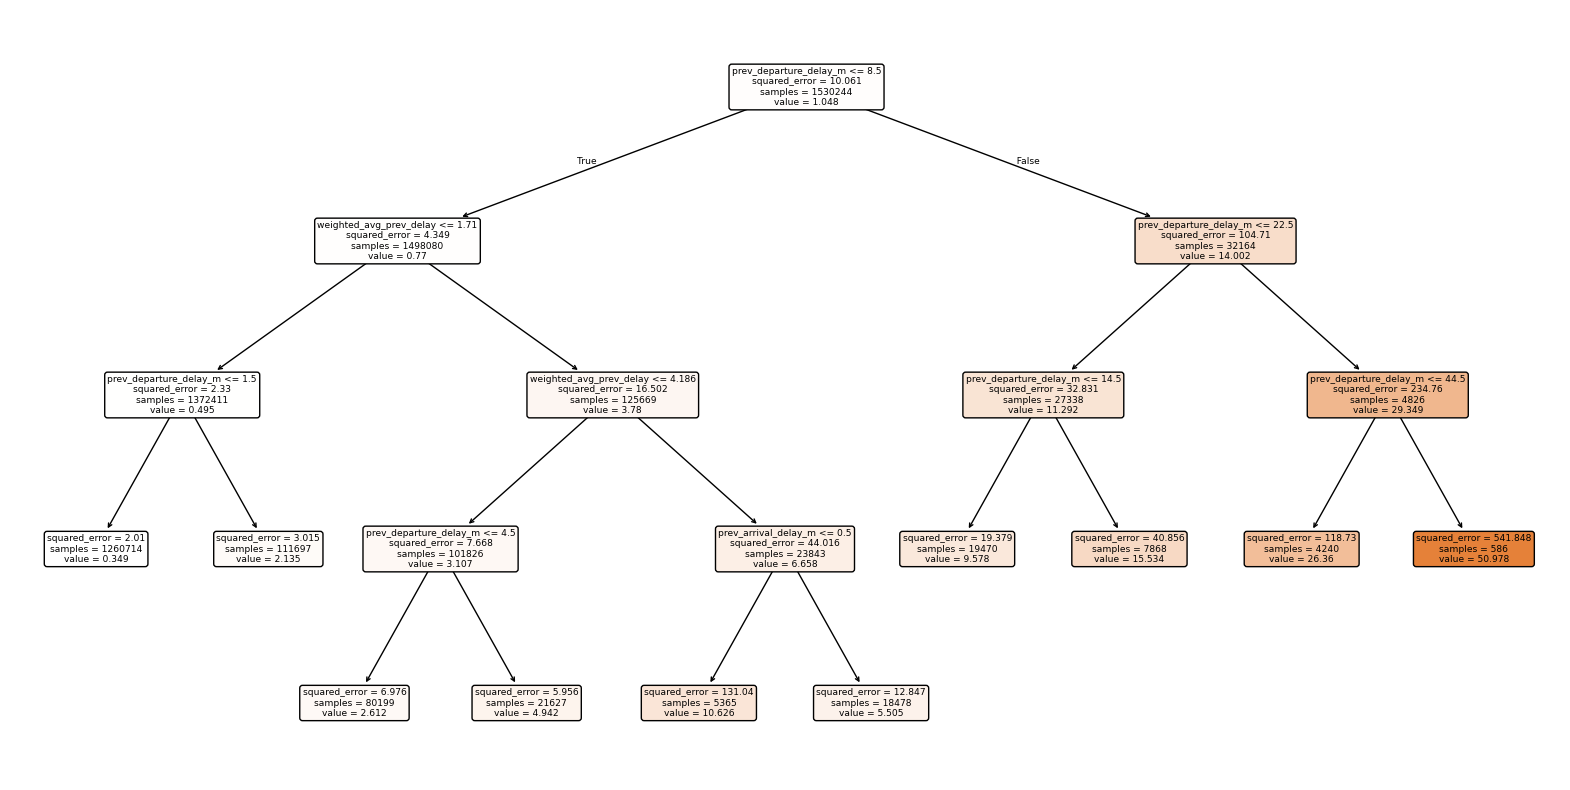

In [8]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Assuming 'regressor' is your trained DecisionTreeRegressor
plt.figure(figsize=(20, 10))  # Adjust size as needed for readability
plot_tree(regression_tree, feature_names=X_train.columns, filled=True, rounded=True)
plt.show()

In [9]:
regression_tree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': 10,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

In [10]:
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    "max_leaf_nodes": [10, 20, 15]
}

In [11]:
grid_search = GridSearchCV(
    estimator=regression_tree, param_grid=param_grid, cv=5, n_jobs=-1)
 
# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)
 
# Print the best hyperparameters and corresponding accuracy score
print("Best Hyperparameters: ", grid_search.best_params_)

Best Hyperparameters:  {'max_depth': 10, 'max_leaf_nodes': 20, 'min_samples_split': 2}


In [12]:
regression_tree = DecisionTreeRegressor(max_depth=5, min_samples_split=2, max_leaf_nodes=20)
# Train on scaled data
regression_tree.fit(X_train, y_train)

# Predict on the test data
y_pred = regression_tree.predict(X_test)

# Calculate Mean Squared Error as a performance metric
mse = mean_absolute_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.7525886602507899


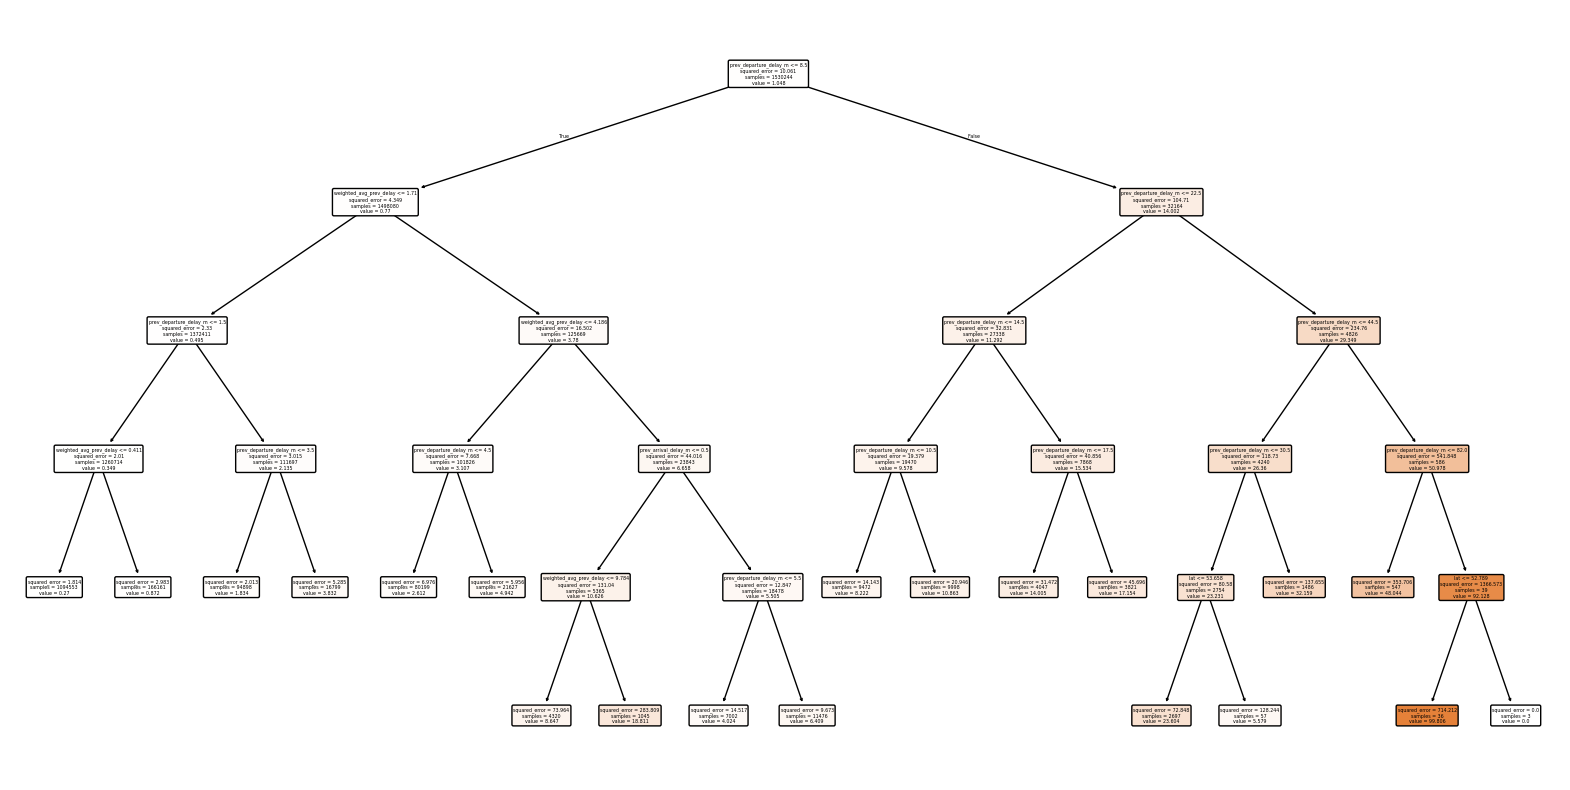

In [13]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Assuming 'regressor' is your trained DecisionTreeRegressor
plt.figure(figsize=(20, 10))  # Adjust size as needed for readability
plot_tree(regression_tree, feature_names=X_train.columns, filled=True, rounded=True)
plt.show()

# Linear Regression

In [14]:
linear_regressor = LinearRegression()

In [15]:
linear_regressor.fit(X_train, y_train)
y_pred = linear_regressor.predict(X_test)

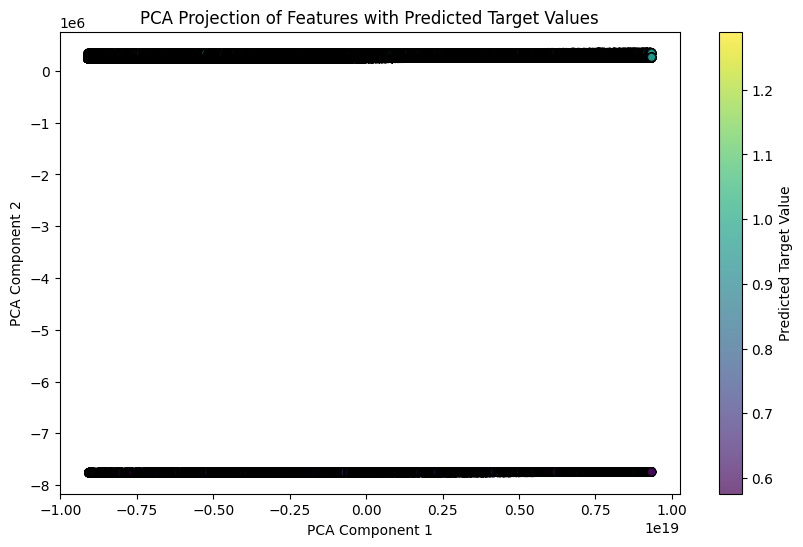

In [16]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Apply PCA to reduce the dimensionality of the features to 2 dimensions
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(X_test)

# Create a scatter plot of the reduced features, colored by predicted target values
plt.figure(figsize=(10, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=y_pred, cmap='viridis', edgecolor='k', alpha=0.7)
plt.colorbar(label='Predicted Target Value')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Projection of Features with Predicted Target Values')
plt.show()

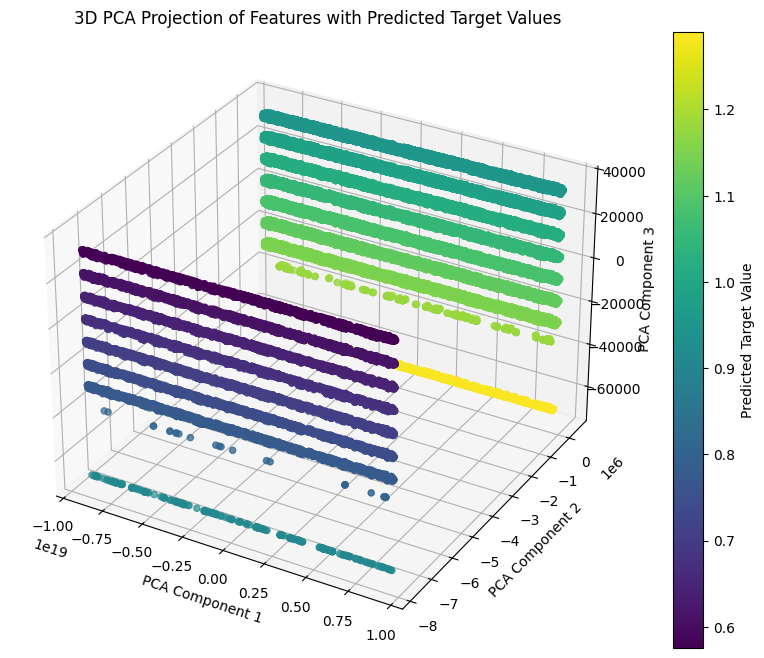

In [17]:
from mpl_toolkits.mplot3d import Axes3D

# Apply PCA to reduce the dimensionality to 3 dimensions
pca = PCA(n_components=3)
reduced_features = pca.fit_transform(X_test)

# Create a 3D scatter plot of the reduced features, colored by predicted target values
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2], c=y_pred, cmap='viridis')
fig.colorbar(scatter, label='Predicted Target Value')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.title('3D PCA Projection of Features with Predicted Target Values')
plt.show()


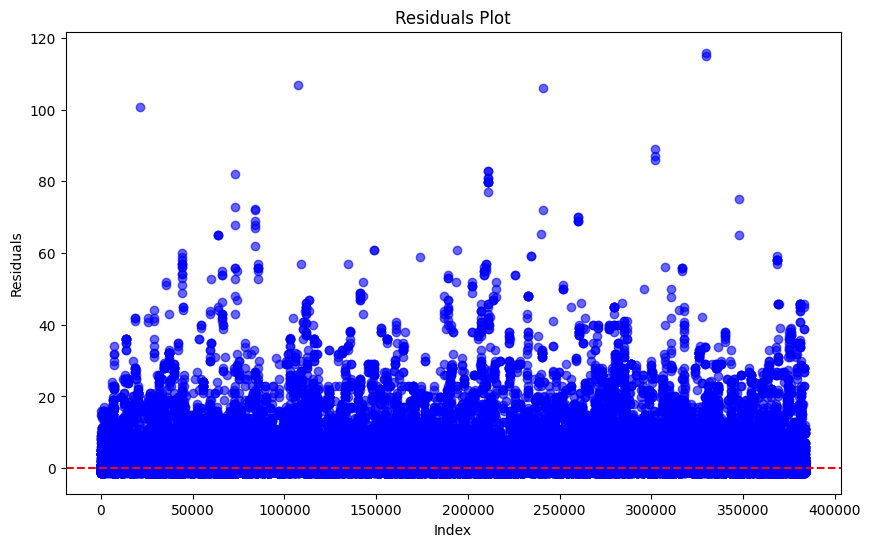

In [18]:
# Assuming you have actual target values (cleaned_target_test)
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals, c='b', alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

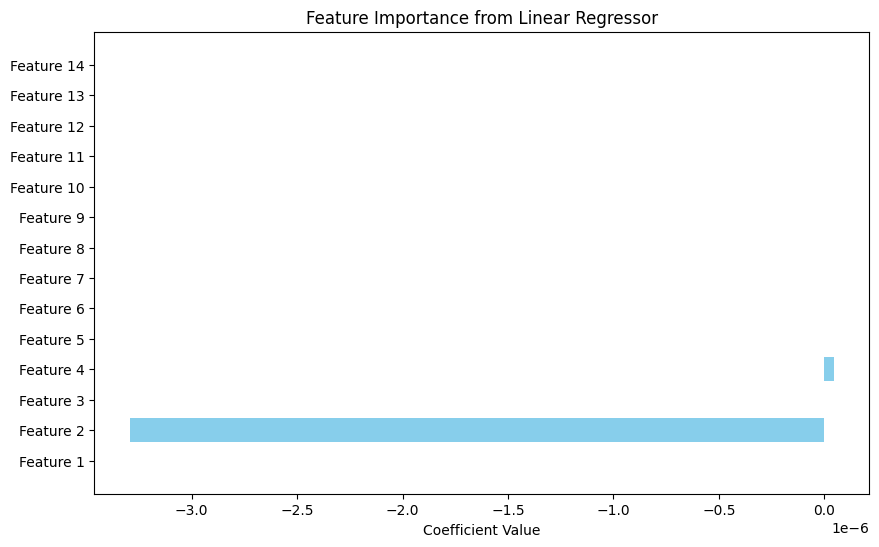

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Get the coefficients from the linear regressor
coefficients = linear_regressor.coef_

# Create a bar plot of the feature importances (coefficients)
features = [f'Feature {i+1}' for i in range(len(coefficients))]
plt.figure(figsize=(10, 6))
plt.barh(features, coefficients, color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance from Linear Regressor')
plt.show()


In [ ]:
# Evaluate the model
mse = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 1.5032701779947677
R^2 Score: 0.0009400824149583542
